# Dataset split
The currently available historical dataset only has data from 2018-08-01 through 2019-06-30.  We will hold out the last 2 months for the test set, leaving 2018-08-01 through 2019-04-31 for the training and validation sets.

The date ranges will be divided like so:

TODO: FIX

<code>|2018-08-01 - Validation - 2018-10-31 | 2018-11-01  ------- Training ------- 2019-04-30 | 2019-05-01 -- Testing -- 2019-06-30|</code>

## Extract Features

After exploring the data in [DataExploration.ipynb](DataExploration.ipynb), you can see that there are 4 obvious things that happen, in regards to delays at Times Sq-42 St.
- Trains stay at a prior station for longer than normal
    - Create a feature based on (time_in_station) per station. The amount of the the most recent train or current train spent in the station.
- Trains start making local stops during normal daytime operations ( See [N Train Schedule](https://new.mta.info/document/9511) )
    - Create a feature that is (time_since_train) per station, how long it has been since the last train departed a station
- Some trains start running backwards
    - having a relative velocity of the train makes sense and as a far term goal, there should be southbound data added for if a train switches from northbound -> southbound -> northbound
- There are large gaps between trains that are running
    - It is quite possible that this is due to other train lines that share tracks (Q,R,W) are having issues and then delaying the N train, so one might be able to observe the above 2 issues for correlated trains, leading to these gaps

In [1]:
# Create features from minutes data
# relative MTADelayPredict Project
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('2_FeatureEngineering.ipynb')))))
from MTADelayPredict.features import feature_builder
import glob
import os
import pandas as pd
import numpy as np
import sys
data_dir = '../data/raw/status'

start_date = pd.Timestamp('2018-08-01 00:00:00-04:00', tz='US/Eastern')
end_date = pd.Timestamp('2019-04-30 23:59:00-04:00', tz='US/Eastern')

drange = pd.date_range(start_date, end_date, freq='D')

file_list = []
status_dir = os.path.join(data_dir, 'status_northbound_n_new')

min_since_train_list = []
min_in_station_list = []
min_until_train_list = []

for date in drange:
    yyyymm = str(date.year * 100 + date.month)
    yyyymmdd = str(date.year * 10000 + date.month * 100 + date.day)
    filename = os.path.join(status_dir, yyyymm, '{}.h5'.format(yyyymmdd))
    if os.path.exists(filename):
        file_list.append(filename)
        min_since_train_list.append(pd.read_hdf(filename, 'min_since_train'))
        min_in_station_list.append(pd.read_hdf(filename, 'min_in_station'))
        min_until_train_list.append(pd.read_hdf(filename, 'min_until_train'))
    else:
        print("Missing {}".format(yyyymmdd))




Missing 20181009
Missing 20181028
Missing 20181029
Missing 20181030
Missing 20181211
Missing 20190124
Missing 20190406
Missing 20190407
Missing 20190408


In [2]:
min_since_train_df = pd.concat(min_since_train_list)
min_in_station_df = pd.concat(min_in_station_list)
min_until_train_df = pd.concat(min_until_train_list)

In [3]:
#del min_since_train_list
#del min_in_station_list
#del min_until_train_list

# Trim times
Any time we are waiting longer than 60 minutes for a train is probably long enough, and we want to avoid fitting to tails

In [4]:
MAX_MINUTES = 60
min_in_station_df[min_in_station_df > MAX_MINUTES] = 60
min_since_train_df[min_since_train_df > MAX_MINUTES] = 60
min_until_train_df[min_until_train_df > MAX_MINUTES] = 60

# Build Features
Apply log transform, this seems to make a really big difference for fitting larger delays (Better fit for outliers)

In [5]:
from importlib import reload
reload(feature_builder)

#features = feature_builder.FeatureBuilder(min_in_station_df.applymap(np.log), min_since_train_df.applymap(np.log))
#features = feature_builder.FeatureBuilder(min_in_station_df, min_since_train_df)
#features_df = features.features

<module 'MTADelayPredict.features.feature_builder' from '/opt/project/MTADelayPredict/features/feature_builder.py'>

In [6]:
features_df = pd.concat([min_in_station_df, min_since_train_df], axis=1, keys=['min_in_station', 'min_since_train'])

In [7]:
from MTADelayPredict.subway_line import SubwayLine, N_STOP_LIST
from MTADelayPredict.utils import stop_info

stop_info.name2stop_ids('8 Av', N_STOP_LIST)

1267    N02N
Name: stop_id, dtype: object

In [8]:

#features = feature_builder.FeatureBuilder(min_in_station_df, min_since_train_df)
features = feature_builder.FeatureBuilder(min_in_station_df.applymap(np.log), min_since_train_df.applymap(np.log))


In [9]:
features_df = features.features

## Adding temporal information

In [10]:
%psource feature_builder.FeatureBuilder.apply_transforms

    def apply_transforms(self, df):
        features = []
        features.append(df)
        features.append(df.rolling('5T').max())
        features.append(df.rolling('15T').max())
        features.append(df.rolling('30T').max())
        features.append(df.rolling('45T').max())
        features.append(df.rolling('60T').max())
        features.append(df.rolling('90T').max())

        # Use a few shifted rolling means
        rolling_mean_10min = df.rolling('10T').mean()
        features.append(rolling_mean_10min)
        features.append(rolling_mean_10min.shift(5))
        features.append(rolling_mean_10min.shift(10))
        features.append(rolling_mean_10min.shift(15))
        features.append(rolling_mean_10min.shift(20))
        features.append(rolling_mean_10min.shift(30))
        features.append(rolling_mean_10min.shift(40))
        features.append(rolling_mean_10min.shift(50))
        return pd.concat(features, axis=1,\
                         keys=self.TRANSFORMS,
            

# Impute missing data
Within each day, forward fill all nans, then replace the beginning of the day.

This is because for the rolling maximums and means, we are thinking about what is the worst, or average value we have seen.  If there is an unspecified value, it seems reasonable for this to have been the last observation.


In [52]:
#features_df = features_df.groupby(features_df.index.date).fillna(method='ffill')
min_until_train_df = min_until_train_df.groupby(min_until_train_df.index.date).fillna(method='ffill')

Only use dates between 06:00 - 19:00

In [53]:
max_wait_df = min_until_train_df.rolling(10, center=True).max()

In [54]:
features_df = features_df.between_time('6:00', '19:00')
min_until_train_df = min_until_train_df.between_time('6:00', '19:00')
max_wait_df = max_wait_df.between_time('6:00', '19:00')

Don't use weekends

In [55]:
(max_wait_df['R16N'] > 30).sum()

1423

In [56]:
min_until_train_df.shape

(145449, 44)

In [57]:
features_df = features_df[features_df.index.dayofweek < 5]


In [58]:
min_until_train_df = min_until_train_df[min_until_train_df.index.dayofweek < 5]

Remaining NaN's after the daily forward fill should be 0, as these are stops that haven't seen a train yet

In [59]:
features_df.fillna(0.0, inplace=True)
min_until_train_df.fillna(0.0, inplace=True)

In [60]:
features_df.dropna().shape

(145449, 1320)

In [61]:
min_until_train_df.dropna().shape

(145449, 44)

# Add the time of day as a predictor

In [62]:
#features_df.loc[:, 'TOD'] = features_df.index.hour

# Add existing baseline predictor

In [63]:
next_scheduled_arrival_df = pd.read_hdf(os.path.join(data_dir, 'next_scheduled_arrival.h5'), key='df')

In [64]:
next_scheduled_arrival_df = next_scheduled_arrival_df.reindex(features_df.index).interpolate().fillna(0.0)

In [65]:
#features_df = pd.concat([features_df, next_scheduled_arrival_df[['R17N', 'R16N', 'R15N', 'R14N']]], axis=1)
#features_df.dropna(inplace=True)

# Resample Distribution

In [66]:
alert_dir = '../data/raw/alerts' 
alerts_df = pd.read_hdf(os.path.join(alert_dir, 'alert_times.h5'), key='alert_times')

In [67]:
alerts_df = alerts_df.reindex(features_df.index).interpolate()

In [68]:
min_until_train_df = min_until_train_df.reindex(features_df.index)

In [69]:
alert_mask = (alerts_df['MinSinceAlert'] < 30) | (alerts_df['MinUntilAlert'] < 30)

In [70]:
resampled_features_df = features_df.loc[alert_mask].copy()
resampled_min_until_train_df = min_until_train_df.loc[alert_mask].copy()

Get weights 

In [71]:
max_wait_df

,D43N,N02N,N03N,N04N,N05N,N06N,N07N,N08N,N09N,N10N,...,R31N,R32N,R33N,R34N,R35N,R36N,R39N,R40N,R41N,R08N
time,,,,,,,,,,,,,,,,,,,,,
2018-08-01 06:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 06:01:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 06:02:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 06:03:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 06:04:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 18:56:00-04:00,10.0,6.0,12.0,12.0,11.0,12.0,11.0,12.0,10.0,9.0,...,12.0,15.0,14.0,12.0,11.0,7.0,7.0,7.0,6.0,12.0
2019-04-30 18:57:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 18:58:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
is_delay = max_wait_df['R16N'] > 15

In [73]:
max_wait_df.index

DatetimeIndex(['2018-08-01 06:00:00-04:00', '2018-08-01 06:01:00-04:00',
               '2018-08-01 06:02:00-04:00', '2018-08-01 06:03:00-04:00',
               '2018-08-01 06:04:00-04:00', '2018-08-01 06:05:00-04:00',
               '2018-08-01 06:06:00-04:00', '2018-08-01 06:07:00-04:00',
               '2018-08-01 06:08:00-04:00', '2018-08-01 06:09:00-04:00',
               ...
               '2019-04-30 18:51:00-04:00', '2019-04-30 18:52:00-04:00',
               '2019-04-30 18:53:00-04:00', '2019-04-30 18:54:00-04:00',
               '2019-04-30 18:55:00-04:00', '2019-04-30 18:56:00-04:00',
               '2019-04-30 18:57:00-04:00', '2019-04-30 18:58:00-04:00',
               '2019-04-30 18:59:00-04:00', '2019-04-30 19:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='time', length=145449, freq=None)

In [74]:
min_until_train_df.shape

(145449, 44)

# Feature Selection

Let's use a Linear SVC to select features

In [75]:
from MTADelayPredict.utils import stop_info
from MTADelayPredict.subway_line import N_STOP_LIST

TIMES_SQUARE_STOPID = stop_info.name2stop_ids('Times Sq - 42 St', N_STOP_LIST).iloc[0]

In [76]:
train_X = features_df.loc['2018-11-01':]
train_y = min_until_train_df.loc['2018-11-01':, TIMES_SQUARE_STOPID]
validate_X = features_df.loc['2018-08-01':'2018-10-31']
validate_y = min_until_train_df.loc['2018-08-01':'2018-10-31', TIMES_SQUARE_STOPID]

In [77]:
# train_X = resampled_features_df.loc['2018-11-01':]
# train_y = resampled_min_until_train_df.loc['2018-11-01':, TIMES_SQUARE_STOPID]
# validate_X = features_df.loc['2018-08-01':'2018-10-31']
# validate_y = min_until_train_df.loc['2018-08-01':'2018-10-31', TIMES_SQUARE_STOPID]

In [78]:
train_is_delay = is_delay.loc['2018-11-01':]
delay_weight = (~train_is_delay).sum() / train_is_delay.sum()

train_X_weight = train_y.copy()
train_X_weight[:] = 1.0
train_X_weight[train_is_delay] = delay_weight


validate_is_delay = is_delay.loc['2018-08-01':'2018-10-31']
delay_weight = (~validate_is_delay).sum() / validate_is_delay.sum()

validate_X_weight = validate_y.copy()
validate_X_weight[:] = 1.0
validate_X_weight[validate_is_delay] = delay_weight

In [79]:
from sklearn.tree import DecisionTreeRegressor
dcr = DecisionTreeRegressor(criterion="mse", max_features=50)

In [80]:
dcr.fit(train_X.values, train_y.values, train_X_weight)

DecisionTreeRegressor(max_features=50)

In [81]:
pred_y = dcr.predict(validate_X)

In [82]:
validate_y = validate_y.loc[validate_X.index]

In [83]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(validate_y, pred_y, squared=False, sample_weight=validate_X_weight)
mse

12.872709097220282

In [84]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(validate_y, next_scheduled_arrival_df.loc[validate_y.index, 'R16N'], squared=False, sample_weight=validate_X_weight)
mse

14.851685219779748

In [85]:
pred_y_df = pd.DataFrame(pred_y, index=validate_y.index)

In [86]:
pred_y_df.index

DatetimeIndex(['2018-08-01 06:00:00-04:00', '2018-08-01 06:01:00-04:00',
               '2018-08-01 06:02:00-04:00', '2018-08-01 06:03:00-04:00',
               '2018-08-01 06:04:00-04:00', '2018-08-01 06:05:00-04:00',
               '2018-08-01 06:06:00-04:00', '2018-08-01 06:07:00-04:00',
               '2018-08-01 06:08:00-04:00', '2018-08-01 06:09:00-04:00',
               ...
               '2018-10-31 18:51:00-04:00', '2018-10-31 18:52:00-04:00',
               '2018-10-31 18:53:00-04:00', '2018-10-31 18:54:00-04:00',
               '2018-10-31 18:55:00-04:00', '2018-10-31 18:56:00-04:00',
               '2018-10-31 18:57:00-04:00', '2018-10-31 18:58:00-04:00',
               '2018-10-31 18:59:00-04:00', '2018-10-31 19:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='time', length=49203, freq=None)

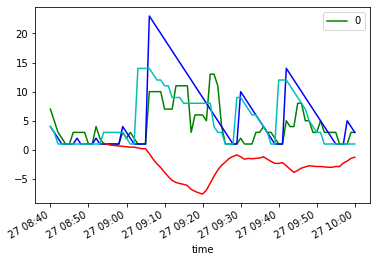

In [87]:
pred_y_df = pd.DataFrame(pred_y, index=validate_y.index)
ax = pred_y_df['2018-08-27 08:40:00':'2018-08-27 10:00:00'].plot(color='g')
validate_y['2018-08-27 08:40:00':'2018-08-27 10:00:00'].plot(ax=ax, color='b')
next_scheduled_arrival_df.loc['2018-08-27 08:40:00':'2018-08-27 10:00:00', 'R16N'].plot(ax=ax, color='c')
(pred_y_df['2018-08-27 08:40:00':'2018-08-27 10:00:00'][0] - validate_y['2018-08-27 08:40:00':'2018-08-27 10:00:00']).rolling(15).mean().plot(color='r', ax=ax)

In [88]:
validate_X.columns

MultiIndex([( 'min_in_station',  'minutes', 'D43N'),
            ( 'min_in_station',  'minutes', 'N02N'),
            ( 'min_in_station',  'minutes', 'N03N'),
            ( 'min_in_station',  'minutes', 'N04N'),
            ( 'min_in_station',  'minutes', 'N05N'),
            ( 'min_in_station',  'minutes', 'N06N'),
            ( 'min_in_station',  'minutes', 'N07N'),
            ( 'min_in_station',  'minutes', 'N08N'),
            ( 'min_in_station',  'minutes', 'N09N'),
            ( 'min_in_station',  'minutes', 'N10N'),
            ...
            ('min_since_train', '10min_50', 'R31N'),
            ('min_since_train', '10min_50', 'R32N'),
            ('min_since_train', '10min_50', 'R33N'),
            ('min_since_train', '10min_50', 'R34N'),
            ('min_since_train', '10min_50', 'R35N'),
            ('min_since_train', '10min_50', 'R36N'),
            ('min_since_train', '10min_50', 'R39N'),
            ('min_since_train', '10min_50', 'R40N'),
            ('min_since_train'

[Text(1395.0, 1223.1, "('min_since_train', '10min_5', 'R36N') <= 2.828\nmse = 70.379\nsamples = 96246\nvalue = 8.458"),
 Text(697.5, 951.3, "('min_in_station', '10min_5', 'R36N') <= 2.066\nmse = 60.37\nsamples = 95496\nvalue = 7.91"),
 Text(348.75, 679.5, "('min_since_train', 'max90', 'R36N') <= 2.674\nmse = 58.225\nsamples = 95452\nvalue = 7.836"),
 Text(174.375, 407.69999999999993, "('min_since_train', 'minutes', 'R17N') <= 0.896\nmse = 49.333\nsamples = 69596\nvalue = 6.821"),
 Text(87.1875, 135.89999999999986, '\n  (...)  \n'),
 Text(261.5625, 135.89999999999986, '\n  (...)  \n'),
 Text(523.125, 407.69999999999993, "('min_in_station', '10min_0', 'R20N') <= 0.087\nmse = 68.445\nsamples = 25856\nvalue = 9.523"),
 Text(435.9375, 135.89999999999986, '\n  (...)  \n'),
 Text(610.3125, 135.89999999999986, '\n  (...)  \n'),
 Text(1046.25, 679.5, "('min_since_train', 'max60', 'R11N') <= 2.602\nmse = 92.861\nsamples = 44\nvalue = 35.641"),
 Text(871.875, 407.69999999999993, "('min_since_trai

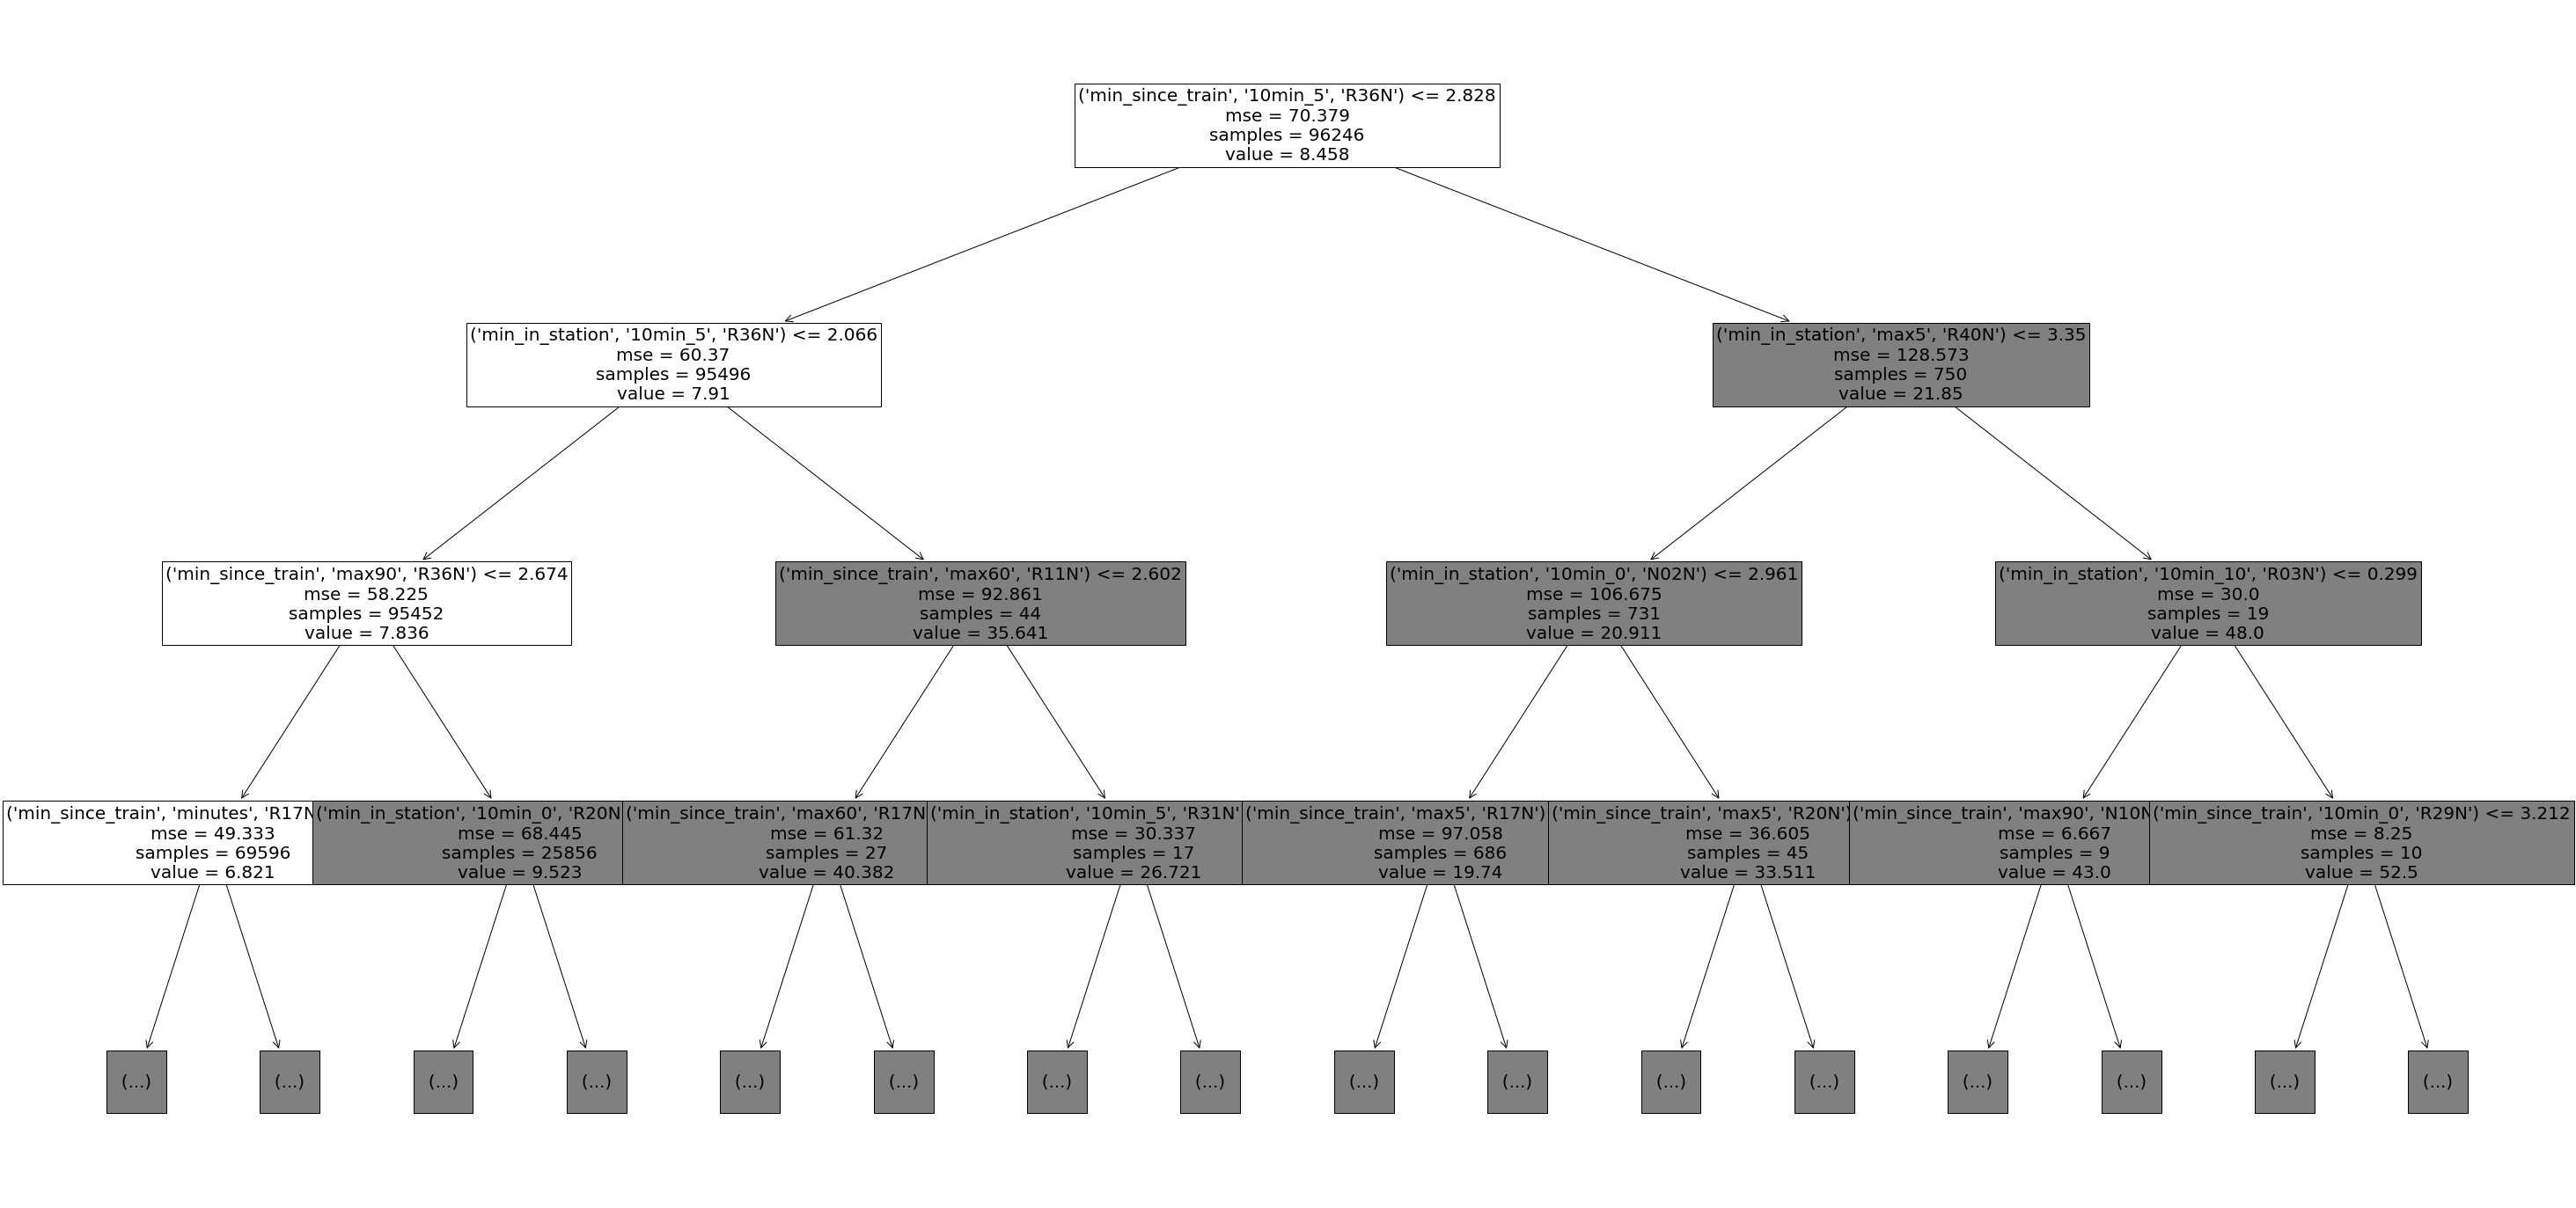

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,25))

from sklearn import tree
tree.plot_tree(dcr, max_depth=3, feature_names=validate_X.columns, fontsize=20)

In [90]:
stop_info.stop_id2name('R15N')

'49 St'

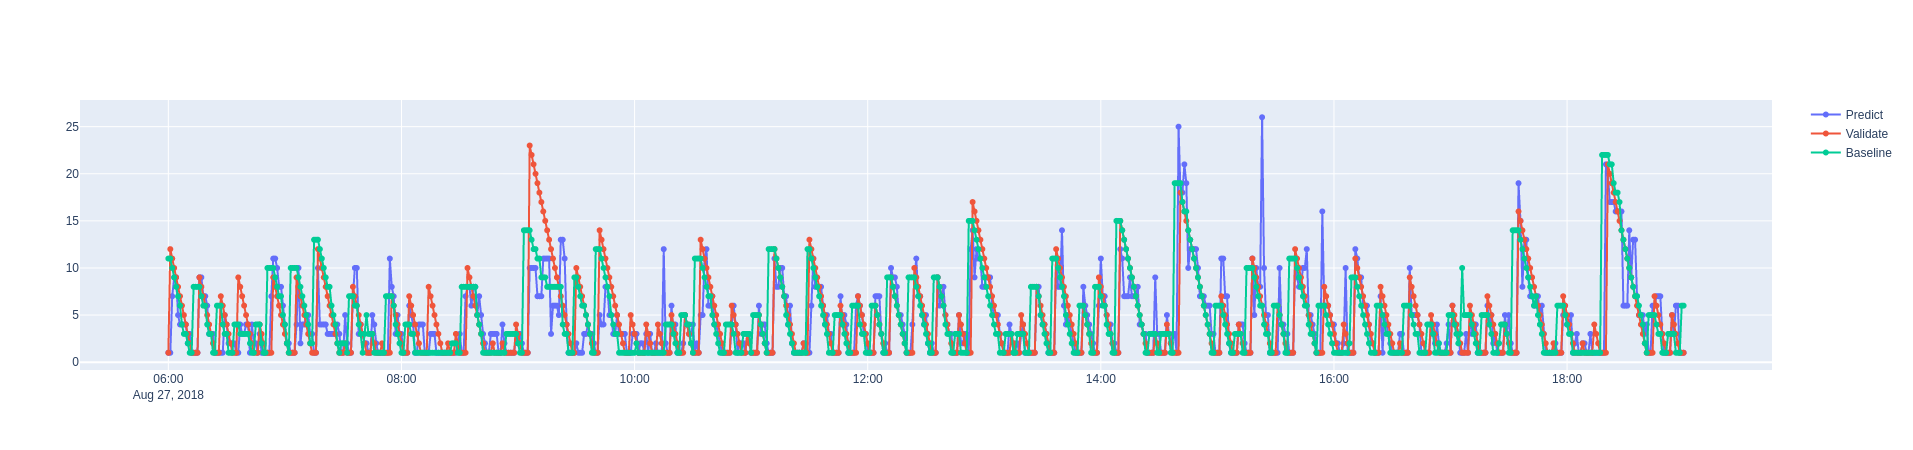

In [91]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(y=pred_y_df.loc['2018-08-27':'2018-08-27', 0], x=pred_y_df.loc['2018-08-27':'2018-08-27'].index,
                    mode='lines+markers',
                    name='Predict'))

fig.add_trace(go.Scatter(y=validate_y.loc['2018-08-27':'2018-08-27'], x=validate_y.loc['2018-08-27':'2018-08-27'].index,
                    mode='lines+markers',
                    name='Validate'))

fig.add_trace(go.Scatter(y=next_scheduled_arrival_df.loc['2018-08-27':'2018-08-27', 'R16N'], x=next_scheduled_arrival_df.loc['2018-08-27':'2018-08-27'].index,
                    mode='lines+markers',
                    name='Baseline'))

fig.show()